In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import json
import pandas as pd

from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
docs = json.load(open("./data_for_STA/data/politically-liberal/statements.json", "r"))
print(len(docs))

1000


In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")

def get_lemmas(text):
    doc = nlp(text)
    # Remove stopwords, punctuation, and lemmatize
    processed = [token.lemma_.lower() for token in doc 
                 if not token.is_stop 
                 and not token.is_punct 
                 and token.text.strip()]
    return processed

categorized_statements_path = "data_for_STA/data/politically-liberal/categorized_statements.json"
categorized_statements = json.load(open(categorized_statements_path, "r"))

catagorized_lemmas = {}

for topic, statements in categorized_statements.items():
    lemmas = []
    for statement in statements:
        lemmas.extend(get_lemmas(statement))
    catagorized_lemmas[topic] = list(set(lemmas))

catagorized_lemmas

{'Political & Ideological Stances': ['democrat',
  'sovereignty',
  'president',
  'theft',
  'fix',
  'republicans',
  'ignorant',
  'care',
  'vote',
  'equality',
  'equal',
  'health',
  'christianity',
  'punish',
  'provide',
  'market',
  'superior',
  'impose',
  'deserve',
  'influence',
  'policing',
  'illegal',
  'faire',
  'gay',
  'fight',
  'citizen',
  'certain',
  'public',
  'income',
  'justify',
  'decision',
  'necessitate',
  'system',
  'politic',
  'nation',
  'leader',
  'unregulated',
  'multiculturalism',
  'union',
  'environment',
  'increase',
  'lead',
  'fair',
  'ideological',
  'humanitarian',
  'oppose',
  'progressive',
  'view',
  'direction',
  'national',
  'culture',
  'return',
  'social',
  'virtue',
  'unemployment',
  'program',
  'significantly',
  'discontinue',
  'goal',
  'basis',
  'support',
  'leave',
  'exception',
  'stand',
  'make',
  'beneficial',
  'discourage',
  'agenda',
  'stamp',
  'platform',
  'protect',
  'rich',
  'churc

# Topic Modeling

In [ ]:
categorized_statements_path = "data_for_STA/data/politically-liberal/categorized_statements.json"
categorized_statements = json.load(open(categorized_statements_path, "r"))

def get_ques_topic(statement):
    for topic, statements in categorized_statements.items():
        if statement in statements:
            return topic
    return None
docs_topic_df = pd.DataFrame({"Document": docs})
docs_topic_df["llm_topic"] = docs_topic_df['Document'].apply(get_ques_topic)
docs_topic_df.groupby('llm_topic').count()

In [ ]:
# hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(min_topic_size=17, language="english", calculate_probabilities=True) # We need the probabilities to visualize

# vectorizer_model=CountVectorizer(stop_words="english")
# cluster_model = KMeans(n_clusters=14)
# topic_model = BERTopic(hdbscan_model=cluster_model, vectorizer_model=vectorizer_model,
#                        language="english", calculate_probabilities=True)

topics, probs = topic_model.fit_transform(docs)

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq#.head()

In [ ]:
temp_df = topic_model.get_document_info(docs)[["Document","Topic", "Name", "Probability"]]

merged_df = docs_topic_df.join(temp_df.set_index("Document"), on="Document", how="inner")
print(merged_df.llm_topic.unique())
selected_tpic = "LGBTQ+ Rights"
topic_df = merged_df.groupby('llm_topic').get_group(selected_tpic)
print(topic_df["Topic"].value_counts())
merged_df[merged_df["Topic"]==-1]

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

In [ ]:
fig = topic_model.visualize_topics()
fig.write_html("analysis/bertopic_visualize_topics.html")
fig

In [ ]:
fig = topic_model.visualize_barchart(top_n_topics=len(topic_freq))
fig.write_html("analysis/bertopic_visualize_barchart.html")
fig

In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])
for topic_id in topic_freq['Topic']:
    if topic_id!=-1:
        print('='*20, topic_id, '='*20)
        print([x[0] for x in topic_model.get_topic(topic_id)])



# Token Set Enrichment Using Logit Lens

## Create Enrichment Dataset

In [1]:
import torch
from tqdm.notebook import tqdm
import plotly.express as px


from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

from transformer_lens.utils import tokenize_and_concatenate

device="cuda"

In [2]:
# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.

# model = HookedTransformer.from_pretrained("gpt2-small")
# sae, cfg_metadata, sparsity = SAE.from_pretrained(
#         release="gpt2-small-res-jb",  # see other options in sae_lens/pretrained_saes.yaml
#         sae_id=f"blocks.8.hook_resid_pre",  # won't always be a hook point
#         device=device,
# )

# model_name = "gemma-2-9b-it"
# model = HookedTransformer.from_pretrained(model_name, device=device, , dtype=torch.bfloat16)
# sae, cfg_metadata, sparsity = SAE.from_pretrained(
#     release="gemma-scope-9b-it-res-canonical",  # see other options in sae_lens/pretrained_saes.yaml
#     sae_id="layer_20/width_131k/canonical",  # won't always be a hook point
#     device=device,
# )

model_name = "meta-llama/Llama-3.1-8B-Instruct"
model = HookedTransformer.from_pretrained(model_name, device=device, dtype=torch.bfloat16)
sae, cfg_metadata, sparsity = SAE.from_pretrained(
    release="llama_scope_lxr_32x",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="l14r_32x",  # won't always be a hook point
    device=device,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B-Instruct into HookedTransformer


In [3]:
sae.W_dec.shape

torch.Size([131072, 4096])

In [5]:
# Feature statistics

import pandas as pd
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer

from sae_lens import SAE


@torch.no_grad()
def get_feature_property_df(sae: SAE, feature_sparsity: torch.Tensor):
    """
    feature_property_df = get_feature_property_df(sae, log_feature_density.cpu())
    """

    W_dec_normalized = (
        sae.W_dec.cpu()
    )  # / sparse_autoencoder.W_dec.cpu().norm(dim=-1, keepdim=True)
    W_enc_normalized = (sae.W_enc.cpu() / sae.W_enc.cpu().norm(dim=-1, keepdim=True)).T

    d_e_projection = (W_dec_normalized * W_enc_normalized).sum(-1)
    b_dec_projection = sae.b_dec.cpu() @ W_dec_normalized.T

    return pd.DataFrame(
        {
            "log_feature_sparsity": feature_sparsity + 1e-10,
            "d_e_projection": d_e_projection,
            # "d_e_projection_normalized": d_e_projection_normalized,
            "b_enc": sae.b_enc.detach().cpu(),
            "b_dec_projection": b_dec_projection,
            "feature": list(range(sae.cfg.d_sae)),  # type: ignore
            "dead_neuron": (feature_sparsity < -9).cpu(),
        }
    )


@torch.no_grad()
def get_stats_df(projection: torch.Tensor):
    """
    Returns a dataframe with the mean, std, skewness and kurtosis of the projection
    """
    mean = projection.mean(dim=1, keepdim=True)
    diffs = projection - mean
    var = (diffs**2).mean(dim=1, keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0), dim=1)
    kurtosis = torch.mean(torch.pow(zscores, 4.0), dim=1)

    return pd.DataFrame(
        {
            "feature": range(len(skews)),
            "mean": mean.numpy().squeeze(),
            "std": std.numpy().squeeze(),
            "skewness": skews.numpy(),
            "kurtosis": kurtosis.numpy(),
        }
    )


@torch.no_grad()
def get_all_stats_dfs(
    gpt2_small_sparse_autoencoders: dict[str, SAE],  # [hook_point, sae]
    gpt2_small_sae_sparsities: dict[str, torch.Tensor],  # [hook_point, sae]
    model: HookedTransformer,
    cosine_sim: bool = False,
):
    stats_dfs = []
    pbar = tqdm(gpt2_small_sparse_autoencoders.keys())
    for key in pbar:
        layer = int(key.split(".")[1])
        sparse_autoencoder = gpt2_small_sparse_autoencoders[key]
        pbar.set_description(f"Processing layer {sparse_autoencoder.cfg.hook_name}")
        W_U_stats_df_dec, _ = get_W_U_W_dec_stats_df(
            sparse_autoencoder.W_dec.cpu(), model, cosine_sim
        )
        log_feature_sparsity = gpt2_small_sae_sparsities[key].detach().cpu()
        W_U_stats_df_dec["log_feature_sparsity"] = log_feature_sparsity
        W_U_stats_df_dec["layer"] = layer + (1 if "post" in key else 0)
        stats_dfs.append(W_U_stats_df_dec)

    return pd.concat(stats_dfs, axis=0)


@torch.no_grad()
def get_W_U_W_dec_stats_df(
    W_dec: torch.Tensor, model: HookedTransformer, cosine_sim: bool = False
) -> tuple[pd.DataFrame, torch.Tensor]:
    W_U = model.W_U.detach().float().cpu()
    if cosine_sim:
        W_U = W_U / W_U.norm(dim=0, keepdim=True)
    dec_projection_onto_W_U = W_dec @ W_U
    W_U_stats_df = get_stats_df(dec_projection_onto_W_U)
    return W_U_stats_df, dec_projection_onto_W_U

In [6]:
sparse_autoencoder = sae
log_feature_sparsity = sparsity.float().cpu() if sparsity is not None else None

W_dec = sparse_autoencoder.W_dec.detach().float().cpu()

# calculate the statistics of the logit weight distributions
W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=False
)
W_U_stats_df_dec["sparsity"] = (
    log_feature_sparsity  # add feature sparsity since it is often interesting.
)
display(W_U_stats_df_dec)

,feature,mean,std,skewness,kurtosis,sparsity
0,0,-1.336977e-06,0.006644,-0.000024,3.264476,None
1,1,-7.461256e-06,0.007449,-0.011193,3.248660,None
2,2,-1.632519e-07,0.007044,0.034516,3.264036,None
3,3,-9.886198e-07,0.005870,0.058434,3.261239,None
4,4,-1.808202e-06,0.006412,0.009447,3.248430,None
...,...,...,...,...,...,...
131067,131067,-2.969854e-06,0.007528,0.021195,3.178234,None
131068,131068,3.539245e-06,0.006346,0.070875,3.221143,None
131069,131069,4.349322e-06,0.008366,0.025023,3.213846,None
131070,131070,-9.868694e-07,0.008835,0.014114,3.230446,None


## Get Enrichment Scores

In [7]:
def get_token_sets(vocab: dict[str, int], prefix='Ġ') -> dict[str, list[int]]:
    
    # Group by category and collect all topic words
    category_tokens = {}
    for category, words in catagorized_lemmas.items():
        words = [f"{prefix}{word}" for word in words]
        # Find matching vocab tokens
        token_ids = [id for token, id in vocab.items() if token in words]
        category_tokens[category] = token_ids
    
    return category_tokens


In [14]:
vocab = model.tokenizer.get_vocab()  # type: ignore

all_token_sets = get_token_sets(vocab, 'Ġ') # '▁'
# for each gene set, convert to string and  print the first 5 tokens
for token_set_name, gene_set in sorted(
    all_token_sets.items(), key=lambda x: len(x[1]), reverse=True
):
    tokens = [model.to_string(id) for id in list(gene_set)][:10]  # type: ignore
    print(f"{token_set_name}, has {len(gene_set)} genes")
    print(tokens)
    print("++++")


Social Welfare & Poverty, has 408 genes
[' disable', ' governmental', ' everybody', ' moral', ' hard', ' economic', ' enact', ' solid', ' fend', ' solve']
++++
Political & Ideological Stances, has 381 genes
[' size', ' unchecked', ' governmental', ' intervention', ' return', ' everybody', ' ideology', ' development', ' kick', ' basis']
++++
Social Equality & Civil Rights, has 333 genes
[' governmental', ' complete', ' everybody', ' far', ' moral', ' basis', ' hard', ' man', ' economic', ' enact']
++++
Climate & Environment, has 171 genes
[' unchecked', ' intervention', ' effect', ' mitigate', ' moral', ' development', ' economic', ' reality', ' relate', ' endanger']
++++
Tax Policy, has 137 genes
[' everybody', ' economic', ' solve', ' taxis', ' entitlement', ' generate', ' pay', ' care', ' society', ' impact']
++++
Traditional Values & Gender Roles, has 128 genes
[' moral', ' basis', ' man', ' fashioned', ' woman', ' traditional', ' value', ' america', ' marriage', ' text']
++++
Healt

In [15]:
features_ordered_by_skew = (
    W_U_stats_df_dec["skewness"].sort_values(ascending=False).head(5000).index.to_list()
)

In [16]:
from sae_lens.tutorial.tsea import (
    get_enrichment_df,
)
# filter our list.
token_sets_index = list(all_token_sets.keys())
token_sets = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}

# calculate the enrichment scores
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U,  # use the logit weight values as our rankings over tokens.
    features_ordered_by_skew,  # subset by these features
    token_sets,  # use token_sets
)

df_enrichment_scores.to_csv(f"analysis/{model_name.split('/')[-1]}_enrichment_scores.csv")

In [17]:
df_enrichment_scores

,107525,6859,28501,72128,75990,32064,97093,84815,77278,17808,...,91649,83106,71097,47645,72256,70380,95106,110081,101792,71104
Political & Ideological Stances,0.123569,0.097262,0.085847,0.118732,0.214144,0.138928,0.148182,0.083715,0.112202,0.122587,...,0.195872,0.169150,0.077608,0.248196,0.258681,0.158385,0.223134,0.221928,0.149529,0.046036
Corporate & Economic Regulation,0.172761,0.053437,0.182591,0.111143,0.239552,0.153438,0.186222,0.127342,0.078650,0.148513,...,0.308760,0.168654,0.162532,0.294608,0.353179,0.115911,0.307484,0.289753,0.098436,0.042994
Social Welfare & Poverty,0.089898,0.087423,0.113600,0.090348,0.200640,0.108220,0.132222,0.097566,0.140648,0.154534,...,0.225968,0.149423,0.051844,0.223876,0.252103,0.125370,0.266121,0.229586,0.128639,0.044440
Healthcare,0.142305,0.134363,0.120357,0.104704,0.325195,0.145837,0.247390,0.111364,0.162107,0.272669,...,0.249783,0.135840,0.173476,0.194881,0.270792,0.211838,0.368078,0.263622,0.168597,0.075677
Tax Policy,0.138546,0.137115,0.102906,0.138560,0.268936,0.220841,0.166839,0.114118,0.082028,0.200115,...,0.281979,0.185686,0.060417,0.212918,0.306861,0.218414,0.324942,0.302696,0.181498,0.073253
Social Equality & Civil Rights,0.120808,0.093027,0.096822,0.100059,0.207983,0.122322,0.110404,0.070385,0.084870,0.131981,...,0.225565,0.149980,0.026218,0.255704,0.225252,0.127524,0.257676,0.195918,0.154108,0.081458
Climate & Environment,0.140715,0.090479,0.126828,0.133856,0.292292,0.155260,0.158641,0.075446,0.106690,0.171123,...,0.243326,0.149534,0.081161,0.303577,0.300252,0.135558,0.276105,0.254126,0.137504,0.052271
Traditional Values & Gender Roles,0.120216,0.129051,0.166997,0.126257,0.236951,0.163368,0.159942,0.112645,0.119724,0.168129,...,0.214824,0.135131,0.046976,0.280376,0.320898,0.182076,0.289273,0.198161,0.161916,0.144769
Immigration & Refugees,0.109049,0.071175,0.121669,0.157775,0.284546,0.091044,0.142447,0.102755,0.109599,0.165192,...,0.273386,0.239145,0.042677,0.189398,0.356646,0.155677,0.309194,0.250331,0.211741,0.090266
Abortion Rights,0.090466,0.064282,0.187709,0.108233,0.273641,0.223663,0.176949,0.096121,0.140059,0.264143,...,0.316856,0.240745,0.189564,0.282416,0.232346,0.131706,0.287263,0.325560,0.225508,0.152799


## Analyze Enrichment Scores

In [18]:
import pandas as pd
import plotly.express as px
from sae_lens.tutorial.tsea import (
    manhattan_plot_enrichment_scores,
    plot_top_k_feature_projections_by_token_and_category,
)

# model_name = "gemma-2-9b-it"
model_name = "meta-llama/Llama-3.1-8B-Instruct"

df_enrichment_scores = pd.read_csv(f"analysis/{model_name.split('/')[-1]}_enrichment_scores.csv", index_col=0)

df_enrichment_scores

,107525,6859,28501,72128,75990,32064,97093,84815,77278,17808,...,91649,83106,71097,47645,72256,70380,95106,110081,101792,71104
Political & Ideological Stances,0.123569,0.097262,0.085847,0.118732,0.214144,0.138928,0.148182,0.083715,0.112202,0.122587,...,0.195872,0.169150,0.077608,0.248196,0.258681,0.158385,0.223134,0.221928,0.149529,0.046036
Corporate & Economic Regulation,0.172761,0.053437,0.182591,0.111143,0.239552,0.153438,0.186222,0.127342,0.078650,0.148513,...,0.308760,0.168654,0.162532,0.294608,0.353179,0.115911,0.307484,0.289753,0.098436,0.042994
Social Welfare & Poverty,0.089898,0.087423,0.113600,0.090348,0.200640,0.108220,0.132222,0.097566,0.140648,0.154534,...,0.225968,0.149423,0.051844,0.223876,0.252103,0.125370,0.266121,0.229586,0.128639,0.044440
Healthcare,0.142305,0.134363,0.120357,0.104704,0.325195,0.145837,0.247390,0.111364,0.162107,0.272669,...,0.249783,0.135840,0.173476,0.194881,0.270792,0.211838,0.368078,0.263622,0.168597,0.075677
Tax Policy,0.138546,0.137115,0.102906,0.138560,0.268936,0.220841,0.166839,0.114118,0.082028,0.200115,...,0.281979,0.185686,0.060417,0.212918,0.306861,0.218414,0.324942,0.302696,0.181498,0.073253
Social Equality & Civil Rights,0.120808,0.093027,0.096822,0.100059,0.207983,0.122322,0.110404,0.070385,0.084870,0.131981,...,0.225565,0.149980,0.026218,0.255704,0.225252,0.127524,0.257676,0.195918,0.154108,0.081458
Climate & Environment,0.140715,0.090479,0.126828,0.133856,0.292292,0.155260,0.158641,0.075446,0.106690,0.171123,...,0.243326,0.149534,0.081161,0.303577,0.300252,0.135558,0.276105,0.254126,0.137504,0.052271
Traditional Values & Gender Roles,0.120216,0.129051,0.166997,0.126257,0.236951,0.163368,0.159942,0.112645,0.119724,0.168129,...,0.214824,0.135131,0.046976,0.280376,0.320898,0.182076,0.289273,0.198161,0.161916,0.144769
Immigration & Refugees,0.109049,0.071175,0.121669,0.157775,0.284546,0.091044,0.142447,0.102755,0.109599,0.165192,...,0.273386,0.239145,0.042677,0.189398,0.356646,0.155677,0.309194,0.250331,0.211741,0.090266
Abortion Rights,0.090466,0.064282,0.187709,0.108233,0.273641,0.223663,0.176949,0.096121,0.140059,0.264143,...,0.316856,0.240745,0.189564,0.282416,0.232346,0.131706,0.287263,0.325560,0.225508,0.152799


In [48]:
df = df_enrichment_scores.T.describe()
df

,Political & Ideological Stances,Corporate & Economic Regulation,Social Welfare & Poverty,Healthcare,Tax Policy,Social Equality & Civil Rights,Climate & Environment,Traditional Values & Gender Roles,Immigration & Refugees,Abortion Rights,Military & Defense Spending,LGBTQ+ Rights,Gun Control
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.132836,0.169970,0.130798,0.169339,0.161470,0.132879,0.151578,0.155282,0.160121,0.192693,0.209276,0.170400,0.222686
std,0.076815,0.083609,0.075687,0.084864,0.085114,0.074992,0.082093,0.079109,0.076779,0.083296,0.093697,0.080275,0.087626
min,0.019243,0.040462,0.018573,0.035284,0.027046,0.021530,0.025417,0.030922,0.033539,0.052549,0.051024,0.041049,0.064282
25%,0.071494,0.104635,0.069793,0.103115,0.093280,0.073298,0.085806,0.092669,0.098806,0.127481,0.135786,0.108635,0.156583
50%,0.118009,0.152799,0.115826,0.152789,0.146613,0.117712,0.134627,0.139244,0.145892,0.176406,0.190590,0.152476,0.206540
75%,0.178350,0.217435,0.176138,0.219183,0.210967,0.179101,0.201687,0.203404,0.207345,0.243490,0.266039,0.217193,0.273087
max,0.585347,0.626262,0.592092,0.644887,0.638798,0.589389,0.663601,0.578827,0.631668,0.644285,0.674066,0.598078,0.669544


In [19]:
token_set_selected =[
    'LGBTQ+ Rights', 
    'Traditional Values & Gender Roles', 
    'Gun Control', 
    # 'Military & Defense Spending', 
    # 'Climate & Environment',
    # 'Political & Ideological Stances'
]
df_enrichment_scores_selected = df_enrichment_scores.loc[token_set_selected]
df_enrichment_scores_selected.shape

(3, 5000)

/tmp/ipykernel_3540300/4142843062.py:20: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



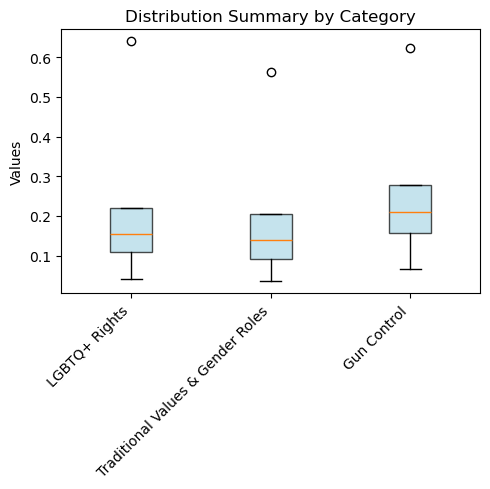

In [26]:
import matplotlib.pyplot as plt

df = df_enrichment_scores_selected.T.describe()
fig, ax = plt.subplots(figsize=(5, 5))
    
# Create box plot data manually from quartiles
categories = df.columns
box_data = []

for col in categories:
    # Box plot expects [min, Q1, median, Q3, max]
    box_data.append([
        df.loc['min', col],
        df.loc['25%', col], 
        df.loc['50%', col],
        df.loc['75%', col],
        df.loc['max', col]
    ])

bp = ax.boxplot(box_data, labels=categories, patch_artist=True)

# Style the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution Summary by Category')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [50]:


fig = manhattan_plot_enrichment_scores(
    df_enrichment_scores_selected,
    label_threshold=0,
    top_n=3,  # use our enrichment scores
)
fig.write_html(f"analysis/{model_name.split('/')[-1]}_manhattan_plot_enrichment_scores.html")
# fig.show()

In [11]:
# Gemma-2-9b-it
df_enrichment_scores.filter(like="LGBTQ+ Rights", axis=0).T.describe().T

,count,mean,std,min,25%,50%,75%,max
LGBTQ+ Rights,5000.0,0.182343,0.081247,0.049424,0.119597,0.166642,0.229501,0.660062


In [12]:
for category in ["LGBTQ+ Rights"]:
    plot_top_k_feature_projections_by_token_and_category(
        token_set_selected,
        df_enrichment_scores,
        category=category,
        dec_projection_onto_W_U=dec_projection_onto_W_U,
        model=model,
        log_y=False,
        histnorm=None,
    )

NameError: name 'dec_projection_onto_W_U' is not defined

In [ ]:
import numpy as np

tmp_df = df_enrichment_scores.apply(lambda x: -1 * np.log(1 - x)).T
color = (
    W_U_stats_df_dec.sort_values("skewness", ascending=False)
    .head(5000)["skewness"]
    .values
)
fig = px.scatter(
    tmp_df.reset_index().rename(columns={"index": "feature"}),
    x="5_climate_change",
    y="22_military_spending",
    marginal_x="histogram",
    marginal_y="histogram",
    # color = color,
    labels={
        "5_climate_change": "Enrichment Score (5_climate_change)",
        "22_military_spending": "Enrichment Score (22_military_spending)",
    },
    height=600,
    width=800,
    hover_name="feature",
)
# reduce point size on the scatter only
fig.update_traces(marker=dict(size=3), selector=dict(mode="markers"))
# annotate any features where the absolute distance between boys names and girls names > 3
for feature in df_enrichment_scores.columns:
    if abs(tmp_df["5_climate_change"][feature] - tmp_df["22_military_spending"][feature]) > 2.9:
        fig.add_annotation(
            x=tmp_df["5_climate_change"][feature] - 0.4,
            y=tmp_df["22_military_spending"][feature] + 0.1,
            text=f"{feature}",
            showarrow=False,
        )


fig.show()